In [ ]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import time
import random
# For showing images
from IPython.display import Image

import os
import sys

# Load mavenn
import mavenn


In [2]:
# Load and split data(hold-out)
#df = pd.read_csv('../result/NA_Epi_AA_Bei89.tsv',sep='\t')
from sklearn.utils import shuffle

def LoadData(input,strain):
    df=pd.read_csv(input,sep='\t')
    df=shuffle(df)
    df_strain=df[(df['strain'] ==strain)]
    df_strain['y']= np.log(df_strain['fit'])
    train, test = np.split(df_strain, [int(.8*len(df_strain))]) 
    index = ['val']*int(round(len(train)*0.2)) + ['train']*int(round(len(train)*0.8)) 
    random.shuffle(index)
    train['set']=index
    train = train.reset_index()
    return train, test
def ProduceAA(num,length):
    AA=[]
    AA_ls='ACDEFGHIKLMNPQRSTVWY'
    for i in range(num):
        aa=''.join(random.choice(AA_ls) for x in range(length))
        AA.append(aa)
    AA = pd.Series(AA)
    return AA

def Train_model(train_set,test_set,Random_test_set,reg):
    
    L = len(train_set.iloc[0,1])
    model = mavenn.Model(L=L,
                         alphabet='protein',
                         gpmap_type='pairwise', 
                         regression_type='GE',
                         ge_noise_model_type='Gaussian',
                         eta_regularization=0.1,
                         theta_regularization=reg)
    # Set training data
    model.set_data(x=train_set["ID"],
                   y=train_set["y"],
                   validation_flags=(train_set['set']=='val'),
                   shuffle=True)
    
    # Fit model to data
    history = model.fit(learning_rate=.005,
                        epochs=1000,
                        batch_size=64,
                        early_stopping=True,
                        early_stopping_patience=5,
                        linear_initialization=False)
    x_test = test_set['ID'].values
    y_test = test_set['y'].values
    random_x_test = Random_test_set.values
    # Predict measurement values (yhat) on test data
    yhat_test = model.x_to_yhat(x_test)
    yhat_random_test = model.x_to_yhat(random_x_test)
    y_random_var = np.var(yhat_random_test)
    y_var = np.var(yhat_test)
    # Compute R^2 between yhat and y_test
    Rsq = np.corrcoef(yhat_test.ravel(), y_test)[0, 1]**2
    # Compute likelihood information
    I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
    # Compute predictive information
    I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)

    I_var_hist = model.history['I_var']
    val_I_var_hist = model.history['val_I_var']
    fig, ax = plt.subplots(1,2,figsize=[8,4])
    ax[0].plot(I_var_hist, label='I_var_train')
    ax[0].plot(val_I_var_hist, label='I_var_val')
    ax[0].axhline(I_var, color='C2', linestyle=':', label='I_var_test')
    ax[0].axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
    ax[0].legend()
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('bits')
    ax[0].set_title('training hisotry')
    ax[0].set_ylim([0, I_pred*1.2]);

    ax[1].plot(model.history['loss'])
    ax[1].plot(model.history['val_loss'])
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('$\mathcal{L}_{\text{like}}$')

    plt.tight_layout()
    plt.show()
    return Rsq,y_var, y_random_var

In [ ]:
#Find the best regularization
reg_ls=[1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,3e-1,5e-1,8e-1,1,1.5,2,1e3]
R2=np.zeros((14,5))
Var=np.zeros((14,5))
Random_test_set=ProduceAA(100,7)
for rep in range(5):
    for reg in reg_ls:
        train_set, test_set = LoadData('../result/NA_compile_results.tsv','HK68') 
        Rsq,Y_var = Train_model(train_set,test_set,Random_test_set,reg)
        index = reg_ls.index(reg)
        R2[index,rep]=Rsq
        Var[index,rep]=Y_var
        print('reg is',reg)

In [55]:
#Find the best regularization
reg_ls=[1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,3e-1,5e-1,8e-1,1,1.5,2,1e3]
R2=np.zeros((14,5))
Var=np.zeros((14,5))
Random_test_set=ProduceAA(100,7)
for rep in range(5):
    for reg in reg_ls:
        train_set, test_set = LoadData('../result/NA_compile_results.tsv','Bei89') 
        Rsq,Y_var = Train_model(train_set,test_set,Random_test_set,reg)
        index = reg_ls.index(reg)
        R2[index,rep]=Rsq
        Var[index,rep]=Y_var
        print('reg is',reg)

<ipython-input-54-4c0faa0b6d2b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0176 sec.
Epoch 1/1000
9/9 [==============================] - 0s 21ms/step - loss: 94.2732 - I_var: -0.2407 - val_loss: 84.7807 - val_I_var: -0.0359
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 85.3909 - I_var: -0.0320 - val_loss: 72.2559 - val_I_var: 0.1939
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 75.1896 - I_var: 0.1881 - val_loss: 65.4437 - val_I_var: 0.2968
Epoch 4/1000
9/9 [==============================] - 0s 7ms/step - loss: 66.6657 - I_var: 0.3733 - val_loss: 60.5527 - val_I_var: 0.3940
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 61.9053 - I_var: 0.4799 - val_loss: 56.9364 - val_I_var: 0.4383
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 57.6477 - I_var: 0.5627 - val_loss: 53.2307 - val_I_var: 0.5097
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step 

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 100 and the array at index 1 has size 173

[0.02750145 0.01641447 0.0271938  0.01930318 0.01203936 0.01533408
 0.01652737 0.02529266 0.03200393 0.00840774 0.01563406 0.02332906
 0.03368436 0.01452497]


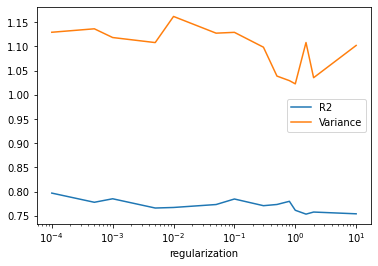

In [48]:
#print(R2)
R2_std=np.std(R2, axis=1)
print(R2_std)
R2_mean = np.average(R2, axis=1)
Var_mean = np.average(Var, axis=1)
plt.plot(reg_ls,R2_mean,label='R2')
plt.plot(reg_ls,Var_mean,label='Variance')
plt.xscale("log")
plt.xlabel("regularization")
plt.legend()

We can plot the GE nonlinearity $g(\phi)$ by creating a grid of $\phi$ values and mapping these to $\hat{y}$ values using `model.phi_to_yhat()`. We can plot confidence intervals of $p(y|\hat{y})$ using the function `model.yhat_to_yq()`.

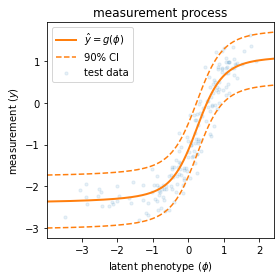

In [120]:
# Predict latent phentoype values (phi) on test data
phi_test = model.x_to_phi(x_test)

# Set phi lims and create grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 90% CI for each yhat
q = [0.05, 0.95] #[0.16, 0.84]
yqs_grid = model.yhat_to_yq(yhat_grid, q=q)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi_test, y_test, color='C0', s=10, alpha=.1, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1', label='90% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()

We can visualize the parameters of the G-P map by calling `mavenn.heatmap`

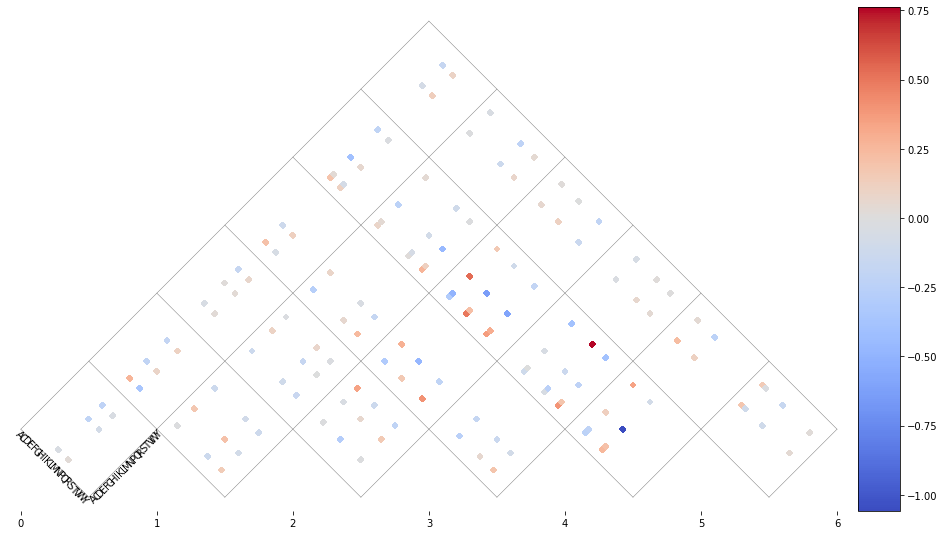

In [121]:
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[16, 10]) 
         
mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);

In [122]:
#epi_map export
data = theta['theta_lclc']


def array2df(input):
    colnames=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
    epi_map=pd.DataFrame()
    for i in range(7):
        for j in range(7):
            map = input[i,:,j,:]
            map_df = pd.DataFrame(map,index=colnames,columns=colnames)
            map_df['L1']=[i+1]*20
            map_df['L2']=[j+1]*20
            epi_map = epi_map.append(map_df)
    return epi_map
                
epi_map=array2df(data)
epi_map=epi_map.dropna(thresh=3)
#print(epi_map)
#reformat the dataframe to L1,L2,aa1,aa2,epi
def df2epimap(input):
    epi_df = pd.DataFrame(columns=["L1","L2","AA1","AA2","EPI"])
    for row_index, row in input.iterrows():
        L1=row['L1']
        L2=row['L2']
        AA1=row_index
        row=row.dropna()
        row=row.drop(labels=['L1', 'L2'])
        for col_index, col in row.items():               
            EPI=col
            AA2=col_index
            add_row = [L1,L2,AA1,AA2,EPI]
            add_series = pd.Series(add_row, index = epi_df.columns)
            epi_df = epi_df.append(add_series,ignore_index=True)
    return epi_df
epi_df = df2epimap(epi_map)
epi_df.to_csv('../result/Bei_epi_64_005-0.1.csv')
print(epi_df)

      L1   L2 AA1 AA2       EPI
0    1.0  2.0   K   D -0.039591
1    1.0  2.0   K   N -0.209668
2    1.0  2.0   K   S -0.215196
3    1.0  2.0   N   D  0.028395
4    1.0  2.0   N   N -0.078027
..   ...  ...  ..  ..       ...
148  6.0  7.0   E   S -0.020657
149  6.0  7.0   K   L -0.103578
150  6.0  7.0   K   S -0.165075
151  6.0  7.0   T   L  0.041387
152  6.0  7.0   T   S  0.023373

[153 rows x 5 columns]
